# Obsea Demo 

In this tutorial we will show how to use obsea to reorient and relocalize an OBS with one mercant ship passsing nearby. For more details, please refer to the associated article.

In [1]:
# Ged rid of annoying warnings
import warnings
warnings.filterwarnings('ignore')

# Import usefull libraries
import numpy as np
import pandas as pd
from obspy.clients.fdsn import Client

# Plot figures inline
%matplotlib inline

# Import obsea
import obsea

## Datasets

Two dataset are compared to retreive the OBS orientation. The OBS recordings and the ship trajectory. Seismological data from the RHUM-RUM network (code YV) is download from the RESIF data center using ObsPy. Ship trajectory are computed from AIS archives. Obsea provide a toy dataset of a few weeks around the RR03 station which is used in this tutorial.

In [2]:
# Seimological
client = Client('RESIF')
inventory = client.get_stations(network='YV', station='RR03', level='response')
station = inventory[0][0]

In [3]:
# AIS
ais = obsea.read_marine_traffic(obsea.get_dataset_path('ais_marine_traffic'))
mmsi_list = pd.read_csv(obsea.get_dataset_path('mmsi_list'), squeeze=True).tolist()
ais = obsea.select_ships(ais, mmsi_list)

The AIS must be processed to extract ships trajectory from isolated logs:

In [4]:
global_tracks = obsea.read_ais(ais, timedelta=pd.Timedelta(24, 'h'))
local_tracks = obsea.select_tracks(global_tracks, station, radius=30_000, cpa=15_000)

One track is selected for this demo:

In [5]:
track = local_tracks.iloc[3]

The associated seismological data is loaded:

In [6]:
st = obsea.load_stream(track, client, inventory, station, '*')

A time-frequecy representation of channels is performed and the pressure (hydrophone) spectrogram is ploted:

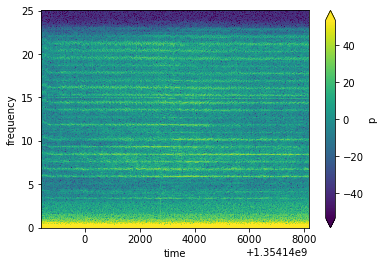

In [7]:
tf = obsea.time_frequency(st, nperseg=1024, step=128, water_level=None)
db = 20*np.log10(np.abs(tf['p']))
db.plot(robust=True, cmap='viridis');

## Orientation

The reorientation workflow is based on direction of arrival computation thanks to the acoustic intensity computation.

First, the azigram is computed:

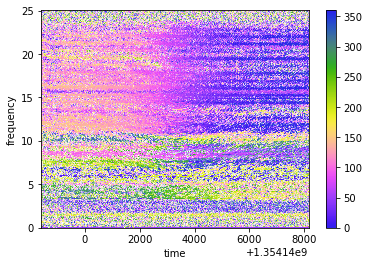

In [8]:
r = obsea.azigram(tf, nperseg=8, step=1)
obsea.plot_azigram(r)

Second, the time-azimuth representation is ploted:

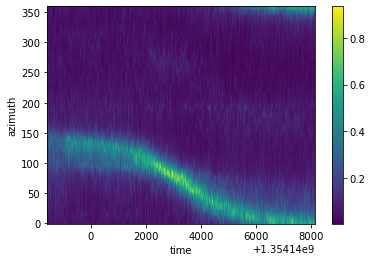

In [9]:
ta = obsea.time_azimuth(r, nperseg=8, step=4, bins=360, sigma=3.0, fmin=1.0, fmax=None)
ta.plot();

Third, knowing the ship trajectory, the orientation-frequency representation can be plotted:

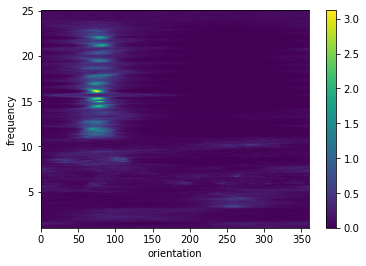

In [10]:
af = obsea.orientation_frequency(r, track, bins=3600, sigma=2.0, fmin=1.0, fmax=None)
af.plot();

Fourth, the orientation-frequency representation is summurized in a pseudo probability density function of orientation.

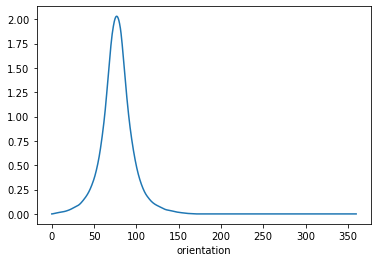

In [11]:
ppdf = obsea.decompose(af)
ppdf.plot();

The maximum (or mode) of this curve is used as the estimation of OBS orientation.

## Localization 

The localization workflow is based on range estimation thanks to cepsral analysis.

First, the cepstrogram is computed:

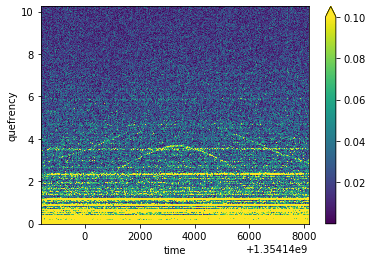

In [12]:
tq = obsea.cepstrogram(tf['p'])
np.abs(obsea.analytic_signal(tq)).plot(vmax=0.1);

Some post processing is applied to extract the relevent part of the signal:

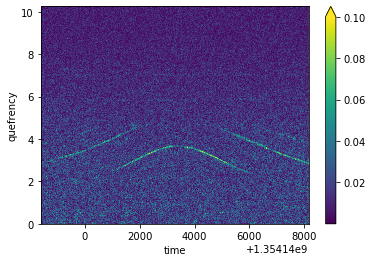

In [13]:
tq = obsea.svd_filter(tq)
tq = obsea.decimate(tq, 'time', 4)
tq = obsea.highpass(tq, 'quefrency')
tq = obsea.resample(tq, 'quefrency', 4)
tq = obsea.analytic_signal(tq)
np.abs(tq).plot(vmax=0.1);

Beamforming in the quefrency domain is performed using the ship trajectory as an antenna:

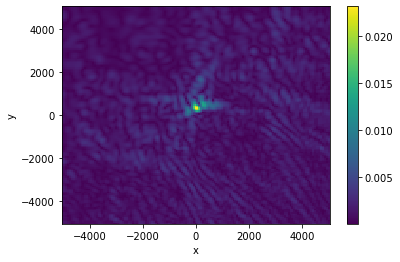

In [14]:
track = track.interp_like(tq)
delayer = obsea.make_delay(track)
xp = np.linspace(-5000, 5000, 141)
yp = np.linspace(-5000, 5000, 141)
beamform = obsea.make_beamform(xp, yp, tq, delayer)
image = beamform(1502, 4340)
np.abs(image).plot();

The maximum of the resulting image is used as the estimate of OBS location.